### Multistep_MLP_with_multiplicative_Decomposition

In [1]:
import datetime
import time
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler
from keras import metrics


from statsmodels.compat.pandas import deprecate_kwarg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
# additive decompose a contrived additive time series
from random import randrange
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose 

# the main library has a small set of functionality
from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import (naive,
                                         drift, 
                                         mean, 
                                         seasonal_naive)
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
data = pd.read_csv('/Users/alket/Desktop/dati/new_data_backfill_forwfill.csv', index_col = 0, 
                   header=0, parse_dates=True)

In [3]:
agg_by_cell = data.groupby(by = ['cell_num'])
print(len(agg_by_cell), 'celle')

221 celle


In [118]:
serie_dati = agg_by_cell.get_group('495-1266')
serie_dati 

,date,cell_num,nr_people,hours,minutes
167,2017-04-16,495-1266,326.0,0.0,0.0
388,2017-04-16,495-1266,330.0,0.0,15.0
609,2017-04-16,495-1266,321.0,0.0,30.0
830,2017-04-16,495-1266,320.0,0.0,45.0
1051,2017-04-16,495-1266,318.0,1.0,0.0
...,...,...,...,...,...
2608630,2017-08-16,495-1266,279.0,22.0,45.0
2608851,2017-08-16,495-1266,280.0,23.0,0.0
2609072,2017-08-16,495-1266,275.0,23.0,15.0
2609293,2017-08-16,495-1266,274.0,23.0,30.0


In [119]:
serie_dati = serie_dati.reset_index()

In [120]:
data4deco = serie_dati['nr_people']
type(data4deco)

pandas.core.series.Series

In [121]:
len(data4deco)

11808

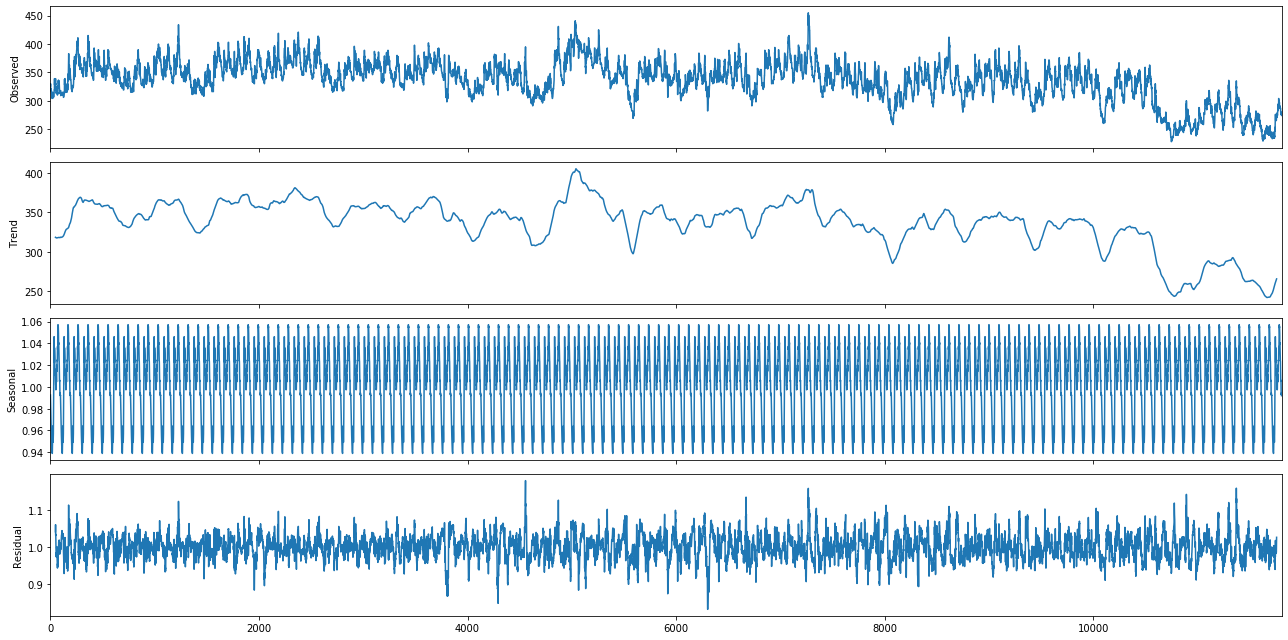

In [122]:
decompfreq = 96
result = seasonal_decompose(data4deco, freq=decompfreq, model='multiplicative') 
with plt.rc_context():
     plt.rc("figure", figsize=(18,9))
     result.plot()
     plt.show()

### Prendi i dati di ciascun componente

In [123]:
data_trend = result.trend.values
data_residual = result.resid.values
data_seasonal = result.seasonal.values

In [124]:
print(data_trend)
start = decompfreq//2
print(start)

data_trend = data_trend[start:]
print('start ', data_trend)
data_trend = data_trend[:-start]
print('finish ', data_trend)
print(data_trend.shape)

data_residual = data_residual[start:]
print('start ', data_residual)
data_residual = data_residual[:-start]
print('finish ', data_residual)
print(data_residual.shape)

data_seasonal = data_seasonal[start:]
print('start ', data_seasonal)
data_seasonal = data_seasonal[:-start]
print('finish ', data_seasonal)
print(data_seasonal.shape)

[nan nan nan ... nan nan nan]
48
start  [318.61458333 318.51041667 318.40625    ...          nan          nan
          nan]
finish  [318.61458333 318.51041667 318.40625    ... 265.21354167 265.57291667
 265.92708333]
(11712,)
start  [1.04136679 1.06055982 1.0316731  ...        nan        nan        nan]
finish  [1.04136679 1.06055982 1.0316731  ... 0.9879179  1.00572963 1.02642727]
(11712,)
start  [1.00966066 1.00355433 1.00154901 ... 0.99438441 0.99268186 0.99198573]
finish  [1.00966066 1.00355433 1.00154901 ... 1.01523151 1.01087798 1.01115639]
(11712,)


In [125]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
         # find the end of this pattern
         end_ix = i + n_steps_in
         out_end_ix = end_ix + n_steps_out
         # check if we are beyond the sequence
         if out_end_ix > len(sequence):
             break
         # gather input and output parts of the pattern
         seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
         X.append(seq_x)
         y.append(seq_y)
    return np.array(X), np.array(y)

In [126]:
def get_forcast_per_component(series, st_in, st_out, train_test_size):
    
    # split into samples
    X, y = split_sequence(series, st_in, st_out)

    train_X, test_X = X[:train_test_size], X[train_test_size:]
    train_y, test_y = y[:train_test_size], y[train_test_size:]

    # define model
    model = Sequential()
    model.add(Dense(500, activation='relu', input_dim=st_in)) 
    model.add(Dense(st_out))

    model.compile(optimizer='adam', loss='mse' , metrics=[metrics.mae, 'accuracy'])

    # fit model
    model.fit(train_X, train_y, batch_size=64, epochs=50, verbose=2)
    
    # predict 
    predicted = []
    for i in range(len(test_X)):
        x_input = test_X[i].reshape(1, st_in)
        yhat = model.predict(x_input, verbose=0)
        
        #predicted.append(np.rint(yhat[0]))   
        predicted.append(np.around(yhat[0], decimals=1)) 
    predicted = np.array(predicted)
    return predicted

In [127]:
n_steps_in, n_steps_out = 80, 20
train_test_size = 9000

forcasted_trend = get_forcast_per_component(data_trend, n_steps_in, n_steps_out, train_test_size)
forcasted_residual = get_forcast_per_component(data_residual, n_steps_in, n_steps_out, train_test_size)
forcasted_season = get_forcast_per_component(data_seasonal, n_steps_in, n_steps_out, train_test_size)

Epoch 1/50
 - 0s - loss: 3808.7814 - mean_absolute_error: 25.8907 - accuracy: 0.0897
Epoch 2/50
 - 0s - loss: 81.7882 - mean_absolute_error: 6.8839 - accuracy: 0.0527
Epoch 3/50
 - 0s - loss: 74.4788 - mean_absolute_error: 6.5708 - accuracy: 0.0407
Epoch 4/50
 - 0s - loss: 67.4805 - mean_absolute_error: 6.2574 - accuracy: 0.0448
Epoch 5/50
 - 0s - loss: 61.0394 - mean_absolute_error: 5.9639 - accuracy: 0.0632
Epoch 6/50
 - 0s - loss: 55.0684 - mean_absolute_error: 5.6652 - accuracy: 0.0687
Epoch 7/50
 - 0s - loss: 46.8618 - mean_absolute_error: 5.2074 - accuracy: 0.0672
Epoch 8/50
 - 0s - loss: 40.8962 - mean_absolute_error: 4.8469 - accuracy: 0.0769
Epoch 9/50
 - 0s - loss: 36.1592 - mean_absolute_error: 4.5668 - accuracy: 0.0929
Epoch 10/50
 - 0s - loss: 31.1601 - mean_absolute_error: 4.2220 - accuracy: 0.1091
Epoch 11/50
 - 0s - loss: 28.9416 - mean_absolute_error: 4.0946 - accuracy: 0.1009
Epoch 12/50
 - 0s - loss: 26.5064 - mean_absolute_error: 3.9217 - accuracy: 0.1290
Epoch 13/5

Epoch 1/50
 - 0s - loss: 0.0297 - mean_absolute_error: 0.0806 - accuracy: 0.0856
Epoch 2/50
 - 0s - loss: 0.0015 - mean_absolute_error: 0.0321 - accuracy: 0.1001
Epoch 3/50
 - 0s - loss: 0.0013 - mean_absolute_error: 0.0297 - accuracy: 0.1231
Epoch 4/50
 - 0s - loss: 0.0011 - mean_absolute_error: 0.0270 - accuracy: 0.1330
Epoch 5/50
 - 0s - loss: 9.2926e-04 - mean_absolute_error: 0.0250 - accuracy: 0.1524
Epoch 6/50
 - 0s - loss: 8.2326e-04 - mean_absolute_error: 0.0234 - accuracy: 0.1662
Epoch 7/50
 - 0s - loss: 7.0397e-04 - mean_absolute_error: 0.0216 - accuracy: 0.1770
Epoch 8/50
 - 0s - loss: 6.4825e-04 - mean_absolute_error: 0.0206 - accuracy: 0.1802
Epoch 9/50
 - 0s - loss: 5.6655e-04 - mean_absolute_error: 0.0191 - accuracy: 0.1924
Epoch 10/50
 - 0s - loss: 5.2091e-04 - mean_absolute_error: 0.0182 - accuracy: 0.1946
Epoch 11/50
 - 0s - loss: 4.6128e-04 - mean_absolute_error: 0.0170 - accuracy: 0.2032
Epoch 12/50
 - 0s - loss: 4.4933e-04 - mean_absolute_error: 0.0167 - accuracy: 

In [140]:
final_prediction = forcasted_trend * forcasted_residual * forcasted_season
final_prediction[:2]

array([[348.6    , 349.7    , 349.9    , 347.4    , 349.8    , 348.1    ,
        348.1    , 348.1    , 346.69998, 349.3    , 347.8    , 348.1    ,
        348.8    , 347.4    , 346.7    , 346.     , 346.     , 347.3    ,
        346.7    , 346.7    ],
       [348.4    , 349.3    , 349.69998, 347.1    , 349.5    , 347.8    ,
        347.8    , 347.9    , 346.4    , 349.     , 347.4    , 347.8    ,
        348.5    , 347.     , 346.3    , 345.5    , 345.6    , 346.9    ,
        346.3    , 346.4    ]], dtype=float32)

In [141]:
X, y = split_sequence(serie_dati['nr_people'].values, n_steps_in, n_steps_out) 

X = X[start:]
#print('start ', X)
X = X[:-start]
#print('finish ', X)
#print(X.shape)

y = y[start:]
#print('start ', y)
y = y[:-start]
#print('finish ', y)
#print(y.shape)

train_X, train_y = X[:train_test_size], X[train_test_size:]
train_y, test_y = y[:train_test_size], y[train_test_size:]

In [142]:
print(final_prediction.shape)
expected = test_y
print(expected.shape)

(2613, 20)
(2613, 20)


In [143]:
difference = abs(expected - final_prediction)

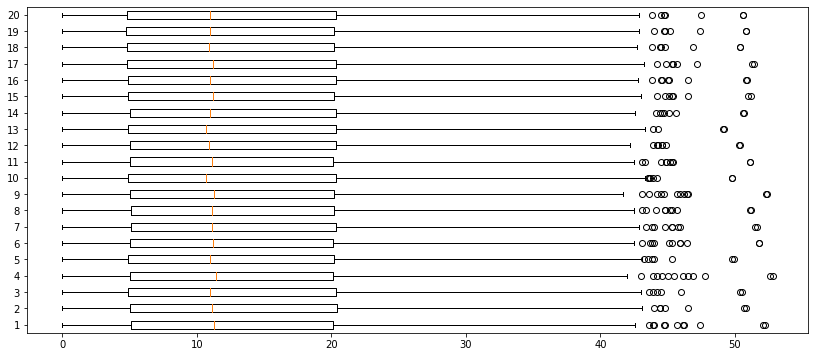

In [144]:
plt.figure(figsize = (14,6))
plt.boxplot(difference, vert= False);
plt.show()

Mean error 13.23516205190198


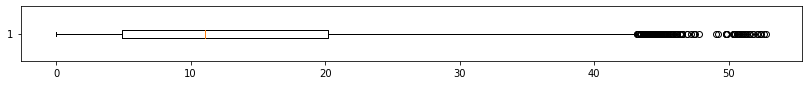

Valori cella


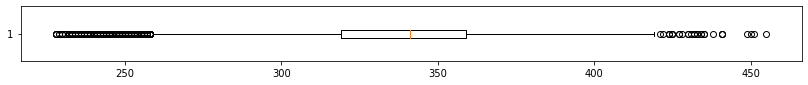

In [145]:
mean_error =  np.reshape(difference, difference.shape[0] * difference.shape[1])
print('Mean error', np.mean(mean_error))
plt.figure(figsize = (14,1))
plt.boxplot(mean_error, vert= False);
plt.show()
print('Valori cella')
plt.figure(figsize = (14, 1))
plt.boxplot(serie_dati['nr_people'].values, vert = False)
plt.show()